# Introduction
In this project, I assume the role of a data scientist at an investment firm tasked with analyzing the stock performance of major big tech companies. I have selected eight influential firms: Meta, Apple, Amazon, Netflix, Google, Nvidia, Microsoft, and Tesla. 

The focus of this project is to delve into the stock data of these tech giants, which are significant components of the S&P 500 index—comprising 500 publicly traded companies on the NYSE and NASDAQ. Since its establishment in 1957, the S&P 500 has been a critical gauge of the U.S. economy, encapsulating the performance of its largest and most influential entities.

Throughout this project, I will engage in extracting, visualizing, analyzing, and forecasting the stock prices of these big tech companies using sophisticated methodologies, including ARIMA, LSTM (Long Short-Term Memory), and Prophet models. The objective is to provide actionable insights into the current health and potential future trends of these companies, aiding in the strategic decision-making process for investors and financial analysts.

# Imports

In [1]:
# Standard library imports
import os
import re
import math
import warnings
from datetime import datetime

# Data handling
import numpy as np
import pandas as pd
import yfinance as yf
from yahoo_fin import stock_info

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.dates import DateFormatter
import matplotlib.dates as mpdates
import matplotlib.dates as mdates

# Utilities
from dateutil.parser import parse
from IPython.display import Image

# Suppressing warnings
warnings.filterwarnings('ignore')

# Set default seaborn style for plots
sns.set(style="whitegrid")

# Scraping the Data
To gather the stock information of S&P 500 firms, we can utilize yfinance and yahoo-fin, which offer APIs that greatly simplify and facilitate web scraping. By employing this web scraper, I succeeded in generating a dataset that updates daily, pulling the stock data of S&P 500 companies.

## How the Web Scraper Works:
* I collect a list of tickers which are the stock abbreviations for all the S&P500 companies. I makes use of the tickers_sp500() function which contains the list of all the the companies that compose the S&P500.
* I iterate over the length of the tickers list and collect the historical stock prices for that particular company. The yf.Ticker() function accepts the name of the company. I then collect the stock prices of the company using history(period = 'max').
* The final file is named using dataframe_names[i] and stored in .csv format.

In [2]:
# Define the specific tickers you are interested in
tickers = ['AAPL', 'AMZN', 'META', 'NFLX', 'GOOG', 'NVDA', 'MSFT', 'TSLA', 'PLTR', 'RIVN', 'LCID', 'AVGO', '^GSPC']

print('Web scraper starting.....')

# Ensure the directory for storing CSV files exists
os.makedirs('stock_data', exist_ok=True)

# Loop through the list of tickers
for ticker in tickers:
    try:
        # Create a Ticker object for each ticker
        stock = yf.Ticker(ticker)
        print(f'Fetching historical prices for {ticker}')
        
        # Remove special characters from ticker symbol
        clean_ticker = re.sub(r'[^a-zA-Z0-9]', '', ticker)  # Keep only alphanumeric characters

        # Get historical prices for this ticker
        historical_stock_prices = stock.history(period='max')

        # Save the data to a CSV file named after the cleaned ticker
        historical_stock_prices.to_csv(f'stock_data/{clean_ticker}.csv')

        print(f'Successfully saved {clean_ticker} data.')

    except Exception as e:
        print(f'Failed to fetch data for {ticker}: {e}')
    
print('Scraping complete.')

Web scraper starting.....
Fetching historical prices for AAPL
Successfully saved AAPL data.
Fetching historical prices for AMZN
Successfully saved AMZN data.
Fetching historical prices for META
Successfully saved META data.
Fetching historical prices for NFLX
Successfully saved NFLX data.
Fetching historical prices for GOOG
Successfully saved GOOG data.
Fetching historical prices for NVDA
Successfully saved NVDA data.
Fetching historical prices for MSFT
Successfully saved MSFT data.
Fetching historical prices for TSLA
Successfully saved TSLA data.
Fetching historical prices for PLTR
Successfully saved PLTR data.
Fetching historical prices for RIVN
Successfully saved RIVN data.
Fetching historical prices for LCID
Successfully saved LCID data.
Fetching historical prices for AVGO
Successfully saved AVGO data.
Fetching historical prices for ^GSPC
Successfully saved GSPC data.
Scraping complete.


In [3]:
# taking a look at the scraped data
pd.read_csv('stock_data/GSPC.csv').tail(10)

Date         Open         High          Low  \
24408  2025-03-05 00:00:00-05:00  5781.359863  5860.589844  5742.350098   
24409  2025-03-06 00:00:00-05:00  5785.870117  5812.080078  5711.640137   
24410  2025-03-07 00:00:00-05:00  5726.009766  5783.009766  5666.290039   
24411  2025-03-10 00:00:00-04:00  5705.370117  5705.370117  5564.020020   
24412  2025-03-11 00:00:00-04:00  5603.649902  5636.299805  5528.410156   
24413  2025-03-12 00:00:00-04:00  5624.839844  5642.189941  5546.089844   
24414  2025-03-13 00:00:00-04:00  5594.450195  5597.779785  5504.649902   
24415  2025-03-14 00:00:00-04:00  5563.850098  5645.270020  5563.850098   
24416  2025-03-17 00:00:00-04:00  5635.600098  5703.520020  5631.120117   
24417  2025-03-18 00:00:00-04:00  5654.529785  5654.529785  5597.759766   

             Close      Volume  Dividends  Stock Splits  
24408  5842.629883  5285970000        0.0           0.0  
24409  5738.520020  5165080000        0.0           0.0  
24410  5770.200195  5705140000        0.0           0.0  
24411  5614.560059  6409370000        0.0           0.0  
24412  5572.069824  6221240000        0.0           0.0  
24413  5599.299805  5219830000        0.0           0.0  
24414  5521.520020  5018980000        0.0           0.0  
24415  5638.939941  4863180000        0.0           0.0  
24416  5675.120117  5031770000        0.0           0.0  
24417  5614.660156  4666270000        0.0           0.0

# Exploratory Data Analysis (EDA)
Before embarking on forecasting the stock prices of big tech companies, it's crucial to first delve into the dataset. Our analysis will focus on the Date, Open, High, Low, Close, and Volume columns within the dataset.

In [5]:
# Define the directory containing stock data
data_dir = 'stock_data'

# Load all CSV files from the specified directory
stock_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
stocks = {}

for file in stock_files:
    ticker = file.replace('.csv', '')
    stocks[ticker] = pd.read_csv(os.path.join(data_dir, file), parse_dates=['Date'])

# Print the start and end dates for each stock dataset
for ticker, df in stocks.items():
    print(f"{ticker}\t\t{df['Date'].min()}\t\t{df['Date'].max()}")

AMZN		1997-05-15 00:00:00-04:00		2025-03-19 00:00:00-04:00
MSFT		1986-03-13 00:00:00-05:00		2025-03-19 00:00:00-04:00
NVDA		1999-01-22 00:00:00-05:00		2025-03-19 00:00:00-04:00
NFLX		2002-05-23 00:00:00-04:00		2025-03-19 00:00:00-04:00
TSLA		2010-06-29 00:00:00-04:00		2025-03-19 00:00:00-04:00
RIVN		2021-11-10 00:00:00-05:00		2025-03-19 00:00:00-04:00
META		2012-05-18 00:00:00-04:00		2025-03-19 00:00:00-04:00
LCID		2020-09-18 00:00:00-04:00		2025-03-19 00:00:00-04:00
GOOG		2004-08-19 00:00:00-04:00		2025-03-19 00:00:00-04:00
GSPC		1927-12-30 00:00:00-05:00		2025-03-18 00:00:00-04:00
AVGO		2009-08-06 00:00:00-04:00		2025-03-19 00:00:00-04:00
PLTR		2020-09-30 00:00:00-04:00		2025-03-19 00:00:00-04:00
AAPL		1980-12-12 00:00:00-05:00		2025-03-19 00:00:00-04:00


In [6]:
def load_data():
    tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'NVDA', 'MSFT', 'TSLA', 'PLTR', 'RIVN', 'LCID', 'AVGO', 'GSPC']
    data_dir = 'stock_data'
    dataframes = {}
    for ticker in tickers:
        df = pd.read_csv(f'{data_dir}/{ticker}.csv', parse_dates=['Date'])
        dataframes[ticker] = df
    return dataframes

dataframes = load_data()
df_meta = dataframes['META']
df_aapl = dataframes['AAPL']
df_amzn = dataframes['AMZN']
df_nflx = dataframes['NFLX']
df_goog = dataframes['GOOG']
df_nvda = dataframes['NVDA']
df_msft = dataframes['MSFT']
df_tsla = dataframes['TSLA']
df_pltr = dataframes['PLTR']
df_rivn = dataframes['RIVN']
df_lcid = dataframes['LCID']
df_avgo = dataframes['AVGO']
df_gspc = dataframes['GSPC']

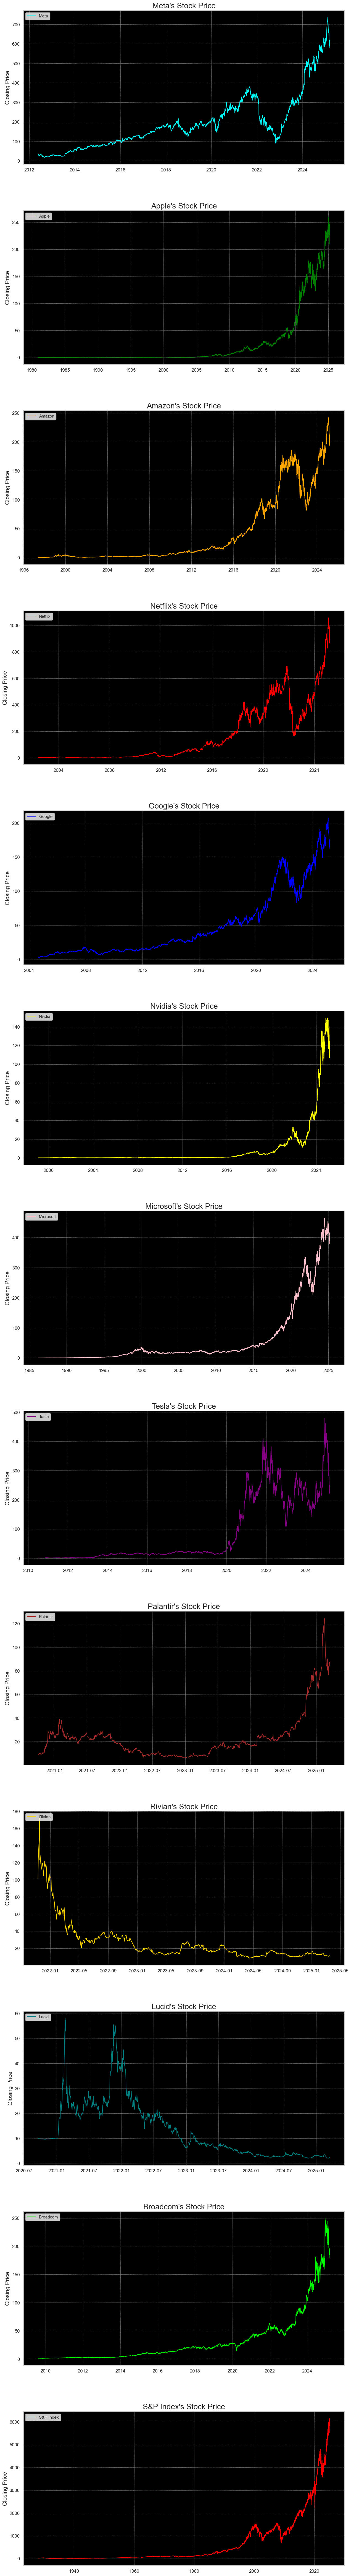

In [8]:
def visualize_bigtech_stock_prices(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla, df_pltr, df_rivn, df_lcid, df_avgo, df_gspc):
    # Prepare figure
    fig, axes = plt.subplots(13, 1, figsize=(15, 120), dpi=100)
    plt.subplots_adjust(hspace=0.3)  # Adjust horizontal space between plots

    # Data to iterate over
    data = [
        (df_meta, "Meta", 'cyan'),
        (df_aapl, "Apple", 'green'),
        (df_amzn, "Amazon", 'orange'),
        (df_nflx, "Netflix", 'red'),
        (df_goog, "Google", 'blue'),
        (df_nvda, "Nvidia", 'yellow'),
        (df_msft, "Microsoft", 'pink'),
        (df_tsla, "Tesla", 'purple'),
        (df_pltr, "Palantir", 'brown'),
        (df_rivn, "Rivian", 'gold'),
        (df_lcid, "Lucid", 'teal'),
        (df_avgo, "Broadcom", 'lime'),
        (df_gspc, "S&P Index", 'red')
    ]
    
    # Generate each subplot
    for ax, (df, title, color) in zip(axes, data):
        ax.set_facecolor('black')
        ax.plot(df['Date'], df['Close'], color=color, label=title)
        ax.set_title(f"{title}'s Stock Price", fontsize=20)
        ax.set_ylabel('Closing Price', fontsize=15)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.legend(loc='upper left')
        ax.grid(True, color='gray', linestyle='--', linewidth=0.5)  # Add gridlines for better readability

    # Show plot
    plt.show()

# Call the function with your dataframes
visualize_bigtech_stock_prices(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla, df_pltr, df_rivn, df_lcid, df_avgo, df_gspc)

* Meta and Apple: Meta's stock shows significant volatility with a pronounced increase around 2020, possibly due to changes in social media consumption and advertising dynamics. Apple displays a consistent long-term upward trend, reflecting its solid growth and market expansion.
* Amazon and Netflix: Amazon's stock also shows a generally upward trend, with notable spikes, likely reflecting market conditions and company milestones. Netflix, while showing growth, has periods of sharp increases and decreases, which might correlate with subscriber growth or competition in streaming services.
* Google and Nvidia: Google's stock, represented in green, has been relatively stable with a gradual increase, indicating steady growth. Nvidia's stock exhibits explosive growth from around 2020 onwards, possibly due to its advancements in GPUs and broader applications in AI and gaming.
* Microsoft and Tesla: Microsoft shows a steady increase over the years with a steeper ascent post-2015, likely due to its successful shift to cloud computing and other tech advancements. Tesla's stock, depicted in purple, shows high volatility, which could be influenced by various factors including market sentiment, technological innovations, and public statements by key executives.

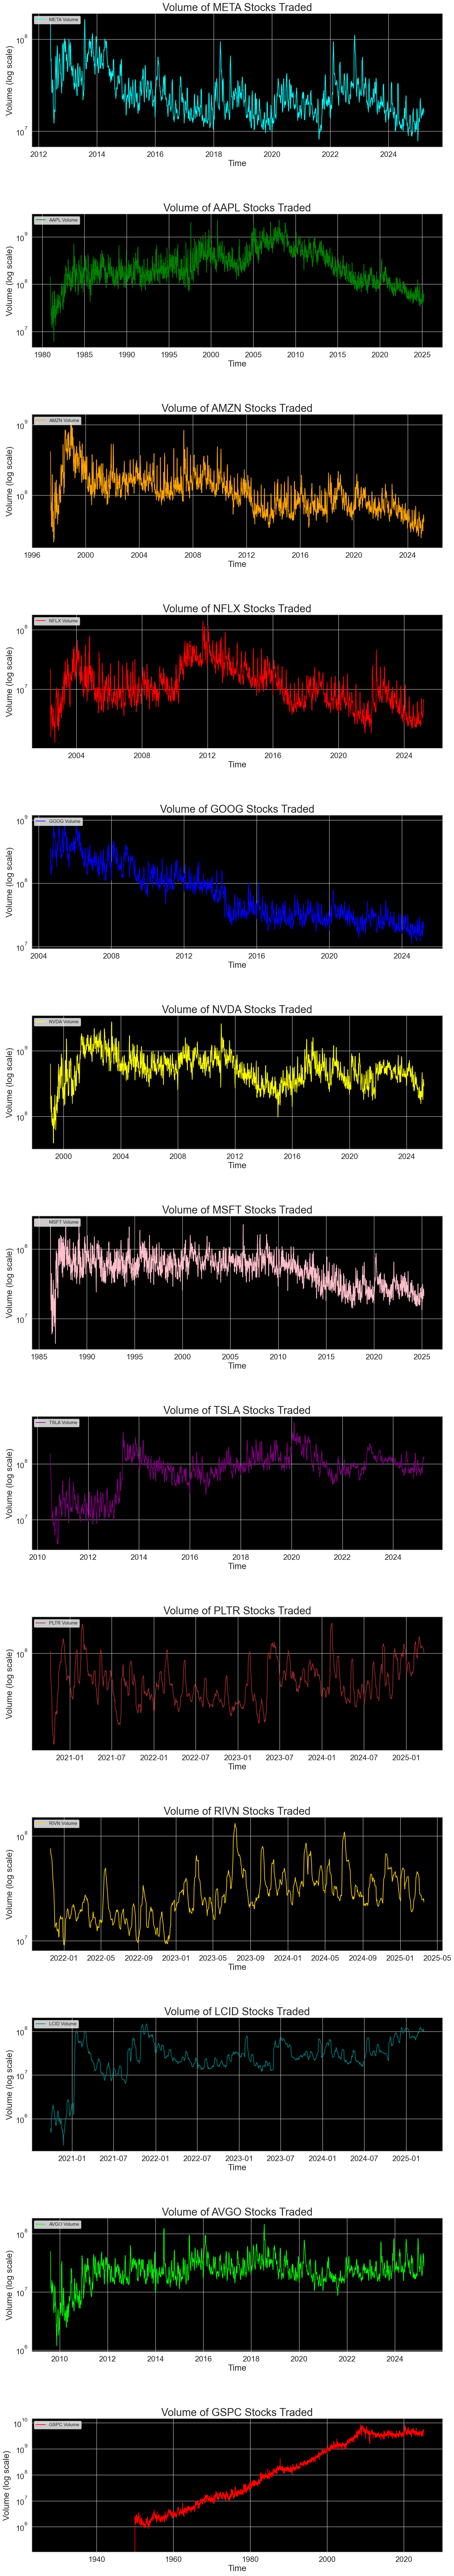

In [9]:
def visualize_bigtech_stock_volume_smoothed(dfs, tickers, colors):
    fig, axes = plt.subplots(13, 1, figsize=(15, 90), dpi=100)
    axes = axes.flatten()  # Flatten the axis array for easier iteration
    plt.subplots_adjust(hspace=1.0)

    for ax, ticker, color in zip(axes, tickers, colors):
        df = dfs[ticker]
        df['Smoothed Volume'] = df['Volume'].rolling(window=7).mean()  # 7-day moving average

        ax.set_facecolor('black')
        ax.semilogy(df['Date'], df['Smoothed Volume'], color=color, label=f'{ticker} Volume')  # Log scale for volume
        ax.set_title(f"Volume of {ticker} Stocks Traded", fontsize=25)
        ax.set_xlabel('Time', fontsize=20)
        ax.set_ylabel('Volume (log scale)', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.5)
    plt.show()

# Example usage
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'NVDA', 'MSFT', 'TSLA', 'PLTR', 'RIVN', 'LCID', 'AVGO', 'GSPC']
colors = ['cyan', 'green', 'orange', 'red', 'blue', 'yellow', 'pink', 'purple', 'brown', 'gold', 'teal', 'lime', 'red']
dfs = {ticker: pd.read_csv(f'stock_data/{ticker}.csv', parse_dates=['Date']) for ticker in tickers}

visualize_bigtech_stock_volume_smoothed(dfs, tickers, colors)

* Meta and Apple: Both companies show significant trading activity, with peaks often corresponding to major corporate announcements or market shifts. Apple's volume shows a gradual increase over time, consistent with its growing market presence.
* Amazon and Netflix: Amazon's trading volume peaks around major business expansions or earnings announcements. Netflix shows less variability compared to others, which might reflect a more stable investor base or less dramatic market-moving news.
* Google and Nvidia: Google maintains a fairly consistent volume, indicative of steady interest and investment. Nvidia's volume shows significant spikes, likely corresponding to its technological advancements or periods of high growth in demand for GPUs.
* Microsoft and Tesla: Microsoft shows a trend of increasing volume over time, aligning with its expanding influence in cloud computing and other sectors. Tesla's volume is notably volatile, reflecting its often-publicized news and developments.

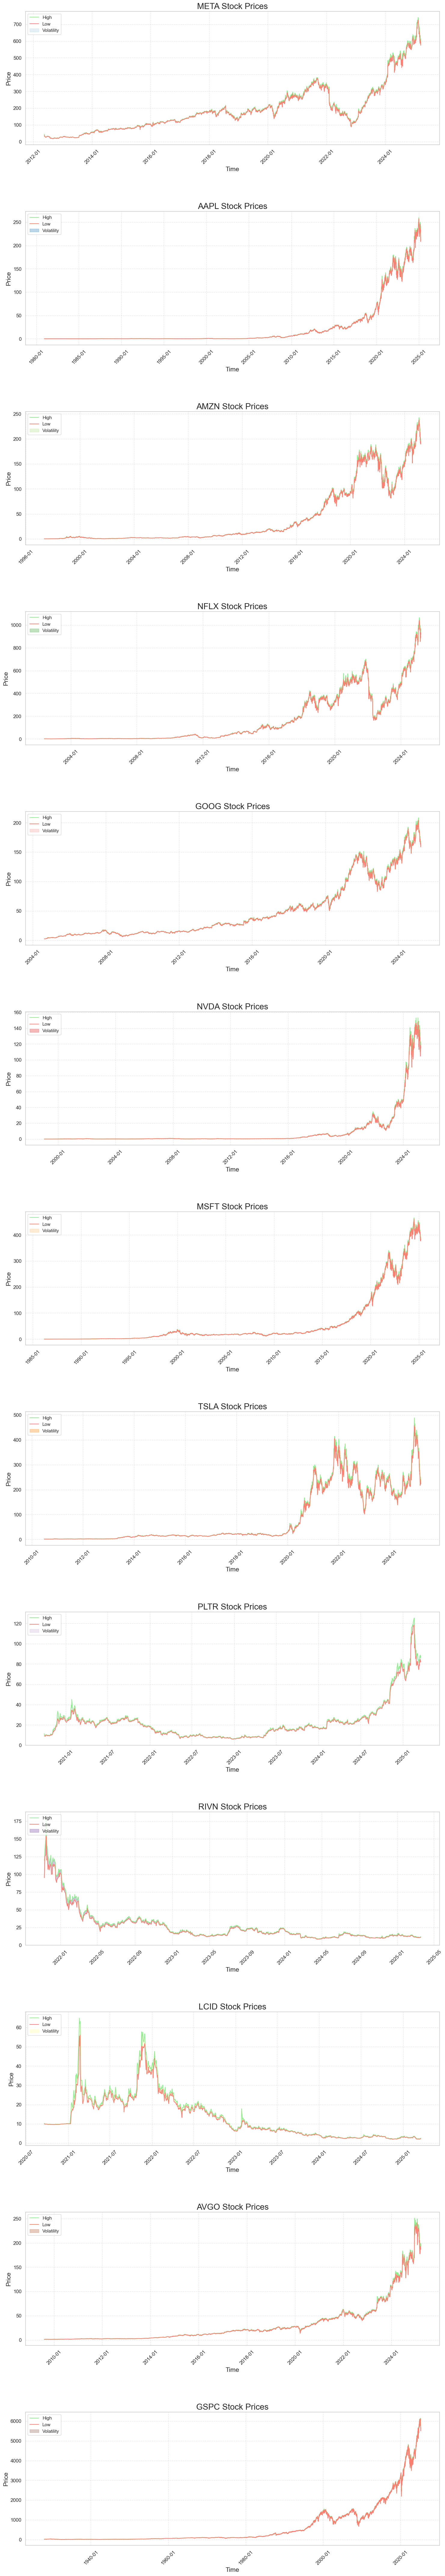

In [11]:
def visualize_bigtech_two_features_over_time_graph(dfs, tickers, colors):
    fig, axes = plt.subplots(13, 1, figsize=(15, 90), dpi=100)
    axes = axes.flatten()  # Flatten the axis array for easier iteration

    # Formatter for date axis
    date_form = DateFormatter("%Y-%m")

    for ax, ticker, color in zip(axes, tickers, colors):
        df = dfs[ticker]
        # Calculate the volatility (high - low)
        df['Volatility'] = df['High'] - df['Low']

        # Plotting high and low prices
        ax.plot(df['Date'], df['High'], color='lightgreen', label='High')
        ax.plot(df['Date'], df['Low'], color='salmon', label='Low')
        # Adding volatility as a filled area
        ax.fill_between(df['Date'], df['Low'], df['High'], color=color, alpha=0.3, label='Volatility')

        # Customizing the plot
        ax.set_title(f'{ticker} Stock Prices', fontsize=20)
        ax.set_xlabel('Time', fontsize=15)
        ax.set_ylabel('Price', fontsize=15)
        ax.xaxis.set_major_formatter(date_form)
        ax.xaxis.set_tick_params(rotation=45, labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.legend(loc='upper left')

        # Optional: Adding grid lines for better readability
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.5)
    plt.show()

# Example usage:
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'NVDA', 'MSFT', 'TSLA', 'PLTR', 'RIVN', 'LCID', 'AVGO', 'GSPC']
colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928', '#8c564b']
dfs = {ticker: pd.read_csv(f'stock_data/{ticker}.csv', parse_dates=['Date']) for ticker in tickers}

visualize_bigtech_two_features_over_time_graph(dfs, tickers, colors)

* Meta (formerly Facebook):
Shows a steady increase with periods of volatility. Sharp rises and falls may be related to major product launches or controversies. Recent increases could reflect strategic shifts or market recoveries.
* Apple:
Exhibits long-term, consistent growth with periodic spikes that likely correspond to new product releases or successful earnings reports. Apple's resilience in maintaining an upward trend might indicate strong market trust and robust business operations.
* Amazon:
Also demonstrates significant growth with notable spikes. The increases are likely influenced by expansion into new markets and services, and strong e-commerce growth especially noticeable during times like the COVID-19 pandemic.
* Netflix:
Shows a more turbulent growth pattern. Rapid rises and falls could correlate with changes in subscriber numbers, strategic company decisions, and market competition influences.
* Google (Alphabet):
Reflects a steady uptrend with less volatility compared to others, indicative of a strong and stable position in the market likely bolstered by diverse income streams beyond just search, such as advertising and cloud computing.
* Nvidia:
Displays a significant growth particularly in recent years, possibly driven by the surge in demand for GPUs for gaming, data centers, and AI technologies.
* Microsoft:
Presents a continuous upward trajectory with increased steepness around the mid-2010s, likely due to successful expansion in cloud computing and other technology solutions.
* Tesla:
Characterized by high volatility with sharp increases and some declines, reflecting market reactions to company news, product launches, and Elon Musk's public statements.

### General Interpretation:
* Growth Trends: All companies show growth over time, reflecting the expanding technology sector and their roles as major players.
* Volatility: Different levels of volatility among these companies could be indicative of their market segments and operational risks. Companies like Tesla and Netflix show more pronounced fluctuations, possibly due to their disruptive business models and market sensitivities.
* Market Confidence: Steady upward trends in companies like Google and Microsoft might suggest strong investor confidence and stable earnings growth.

In [12]:
candlestick_chart_data = ['Date', 'Open', 'High', 'Low', 'Close']
new_meta_df = df_meta[candlestick_chart_data]
new_aapl_df = df_aapl[candlestick_chart_data]
new_amzn_df = df_amzn[candlestick_chart_data]
new_nflx_df = df_nflx[candlestick_chart_data]
new_goog_df = df_goog[candlestick_chart_data]
new_nvda_df = df_nvda[candlestick_chart_data]
new_msft_df = df_msft[candlestick_chart_data]
new_tsla_df = df_tsla[candlestick_chart_data]
new_pltr_df = df_pltr[candlestick_chart_data]
new_rivn_df = df_rivn[candlestick_chart_data]
new_lcid_df = df_lcid[candlestick_chart_data]
new_avgo_df = df_avgo[candlestick_chart_data]
new_gspc_df = df_gspc[candlestick_chart_data]

def create_moving_averages_columns(company_data):
    days_for_moving_averages = [10, 50, 100]
    
    for moving_averages in days_for_moving_averages:
        column = f'MA for {moving_averages} days'
        company_data[column] = company_data['Close'].rolling(moving_averages).mean()
        
    return company_data

new_meta_df = create_moving_averages_columns(new_meta_df)
new_aapl_df = create_moving_averages_columns(new_aapl_df)
new_amzn_df = create_moving_averages_columns(new_amzn_df)
new_nflx_df = create_moving_averages_columns(new_nflx_df)
new_goog_df = create_moving_averages_columns(new_goog_df)
new_nvda_df = create_moving_averages_columns(new_nvda_df)
new_msft_df = create_moving_averages_columns(new_msft_df)
new_tsla_df = create_moving_averages_columns(new_tsla_df)
new_pltr_df = create_moving_averages_columns(new_pltr_df)
new_rivn_df = create_moving_averages_columns(new_rivn_df)
new_lcid_df = create_moving_averages_columns(new_lcid_df)
new_avgo_df = create_moving_averages_columns(new_avgo_df)
new_gspc_df = create_moving_averages_columns(new_gspc_df)

new_gspc_df.tail(10)

Date         Open         High          Low  \
24408  2025-03-05 00:00:00-05:00  5781.359863  5860.589844  5742.350098   
24409  2025-03-06 00:00:00-05:00  5785.870117  5812.080078  5711.640137   
24410  2025-03-07 00:00:00-05:00  5726.009766  5783.009766  5666.290039   
24411  2025-03-10 00:00:00-04:00  5705.370117  5705.370117  5564.020020   
24412  2025-03-11 00:00:00-04:00  5603.649902  5636.299805  5528.410156   
24413  2025-03-12 00:00:00-04:00  5624.839844  5642.189941  5546.089844   
24414  2025-03-13 00:00:00-04:00  5594.450195  5597.779785  5504.649902   
24415  2025-03-14 00:00:00-04:00  5563.850098  5645.270020  5563.850098   
24416  2025-03-17 00:00:00-04:00  5635.600098  5703.520020  5631.120117   
24417  2025-03-18 00:00:00-04:00  5654.529785  5654.529785  5597.759766   

             Close  MA for 10 days  MA for 50 days  MA for 100 days  
24408  5842.629883     5931.177979     5988.099189      5955.302993  
24409  5738.520020     5893.277979     5985.527988      5954.767793  
24410  5770.200195     5868.985010     5982.314990      5954.669297  
24411  5614.560059     5832.116016     5975.124795      5952.664600  
24412  5572.069824     5793.797998     5965.765391      5949.786797  
24413  5599.299805     5758.121973     5956.999590      5947.627197  
24414  5521.520020     5724.116992     5948.013193      5944.417695  
24415  5638.939941     5692.560986     5942.653193      5942.392393  
24416  5675.120117     5675.100977     5938.522998      5940.496895  
24417  5614.660156     5658.752002     5933.445205      5938.103696

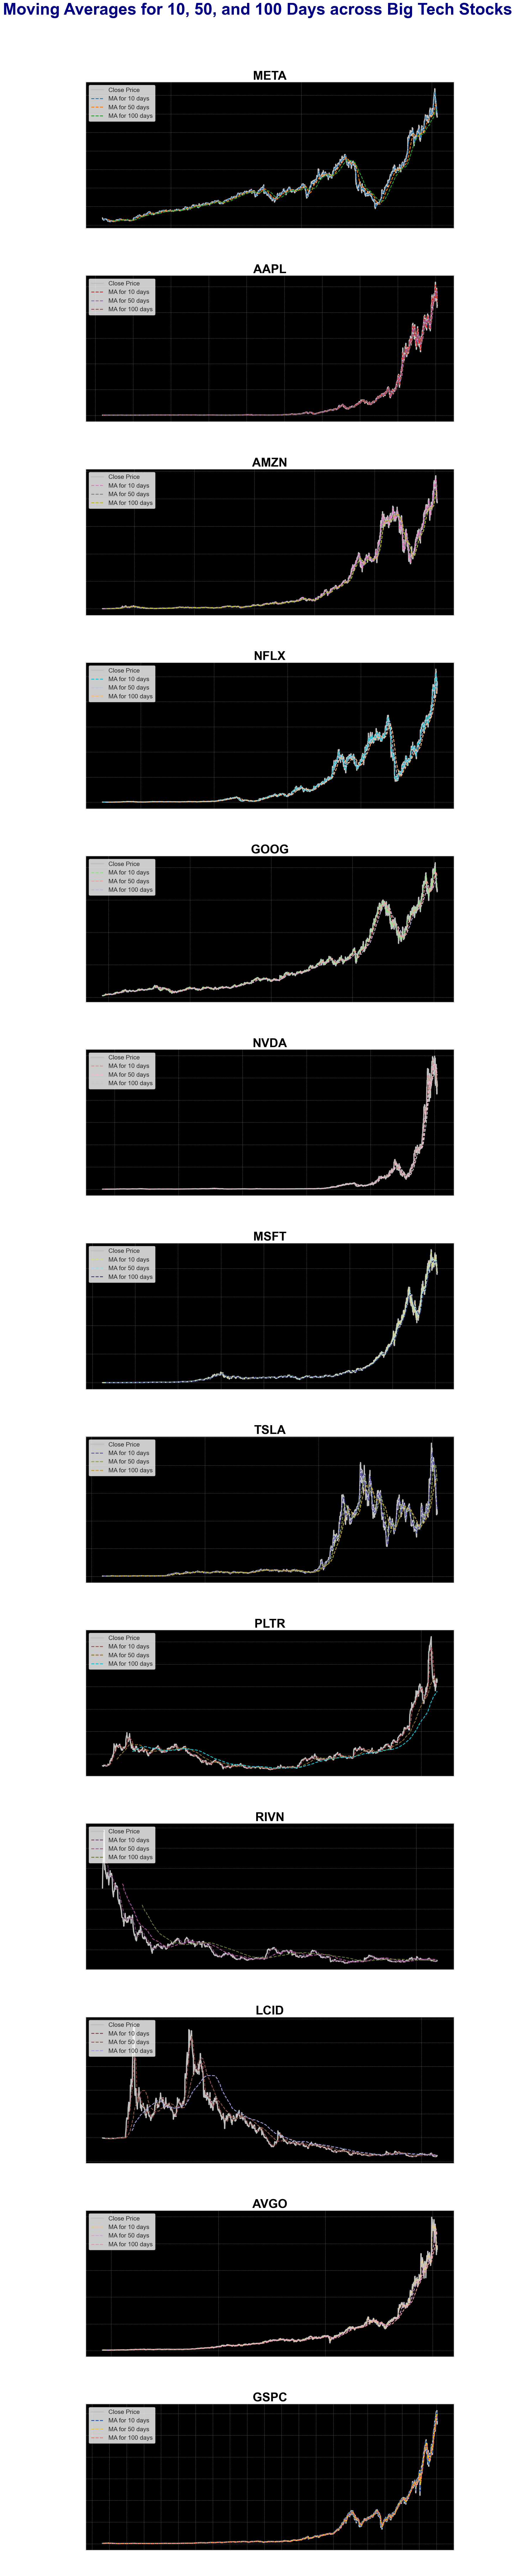

In [14]:
def visualize_moving_averages(dfs, tickers, time, feature, mas, colors):
    # Create a figure and set of subplots
    fig, axes = plt.subplots(13, 1, figsize=(15, 90), dpi=100)
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Configure the overall figure's title
    plt.suptitle('Moving Averages for 10, 50, and 100 Days across Big Tech Stocks', fontsize=40, fontweight='bold', color='navy')

    # Loop through the dataframes and corresponding axes
    for ax, ticker, color in zip(axes, tickers, colors):
        df = dfs[ticker]
        
        # Plot the closing prices and each moving average
        ax.plot(df[time], df[feature], label='Close Price', color='silver', linewidth=3)
        for ma, c in zip(mas, color):
            ax.plot(df[time], df[ma], label=ma, color=c, linewidth=2, linestyle='--')
        
        # Setting title and labels for each subplot
        ax.set_title(f'{ticker}', fontsize=30, fontweight='bold', color='black')
        ax.set_xlabel('Time', fontsize=25, color='white')
        ax.set_ylabel('Price (USD)', fontsize=25, color='white')
        
        # Format the date on the x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Only show year every 5 years
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Show year only
        ax.xaxis.set_tick_params(labelsize=20, colors='white')
        ax.yaxis.set_tick_params(labelsize=20, colors='white')
        
        # Set legend
        ax.legend(fontsize=15, loc='upper left')
        
        # Set grid for better readability
        ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')
        
        # Set facecolor for each subplot for better contrast
        ax.set_facecolor('black')
    
    # Adjust layout to prevent overlap and ensure clarity
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Example usage
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG', 'NVDA', 'MSFT', 'TSLA', 'PLTR', 'RIVN', 'LCID', 'AVGO', 'GSPC']
colors = [
    ('#1f77b4', '#ff7f0e', '#2ca02c'),  # Colors for META
    ('#d62728', '#9467bd', '#8c564b'),  # Colors for AAPL
    ('#e377c2', '#7f7f7f', '#bcbd22'),  # Colors for AMZN
    ('#17becf', '#aec7e8', '#ffbb78'),  # Colors for NFLX
    ('#98df8a', '#ff9896', '#c5b0d5'),  # Colors for GOOG
    ('#c49c94', '#f7b6d2', '#c7c7c7'),  # Colors for NVDA
    ('#dbdb8d', '#9edae5', '#393b79'),  # Colors for MSFT
    ('#5254a3', '#8ca252', '#bd9e39'),  # Colors for TSLA
    ('#ad494a', '#8c6d31', '#17becf'),  # Colors for PLTR
    ('#7b4173', '#a55194', '#637939'),  # Colors for RIVN
    ('#843c39', '#8c564b', '#9c9ede'),  # Colors for LCID
    ('#e7cb94', '#de9ed6', '#e7969c'),   # Colors for AVGO
    ('#1a55a5', '#ffcc00', '#ff6f61')   # Colors for GSPC
]
mas = ['MA for 10 days', 'MA for 50 days', 'MA for 100 days']
dfs = {
    ticker: eval(f'new_{ticker.lower()}_df') for ticker in tickers
}

visualize_moving_averages(dfs, tickers, 'Date', 'Close', mas, colors)

1. Meta
- Displays significant volatility with a responsive 10-day moving average, indicative of reactive market conditions. Longer moving averages show a smoother general trend.
1. Apple
- Shows a strong upward trajectory with the 10-day moving average closely tracking sharp rises, suggesting rapid reactions to positive market or company developments.
3. Amazon
- Depicts overall growth with periodic fluctuations. The 100-day moving average indicates a stable, long-term upward trend amidst short-term volatility.
4. Netflix
- Features a turbulent price history with a notable recovery or growth phase. Moving averages converge and diverge around price spikes, reflecting changes in investor sentiment.
5. Google
- Shows consistent long-term growth. The 100-day moving average acts as a baseline, showing less volatility, while shorter averages respond to recent events.
6. Nvidia
- Illustrates periods of steep incline followed by stability. The 10-day moving average highlights rapid shifts, possibly due to external market forces or major announcements.
7. Microsoft
- Features gradual long-term growth with periodic spikes. The 100-day moving average smooths out fluctuations, indicating sustained growth.
8. Tesla
- Depicts a sharp decline followed by high volatility. Moving averages tightly converge during the decline, suggesting a bearish trend, and show fluctuations as the stock becomes volatile.

In [15]:
new_meta_df['Daily Return'] = new_meta_df['Close'].pct_change()
new_aapl_df['Daily Return'] = new_aapl_df['Close'].pct_change()
new_amzn_df['Daily Return'] = new_amzn_df['Close'].pct_change()
new_nflx_df['Daily Return'] = new_nflx_df['Close'].pct_change()
new_goog_df['Daily Return'] = new_goog_df['Close'].pct_change()
new_nvda_df['Daily Return'] = new_nvda_df['Close'].pct_change()
new_msft_df['Daily Return'] = new_msft_df['Close'].pct_change()
new_tsla_df['Daily Return'] = new_tsla_df['Close'].pct_change()
new_pltr_df['Daily Return'] = new_pltr_df['Close'].pct_change()
new_rivn_df['Daily Return'] = new_rivn_df['Close'].pct_change()
new_lcid_df['Daily Return'] = new_lcid_df['Close'].pct_change()
new_avgo_df['Daily Return'] = new_avgo_df['Close'].pct_change()
new_gspc_df['Daily Return'] = new_gspc_df['Close'].pct_change()

new_gspc_df.tail()

Date         Open         High          Low  \
24413  2025-03-12 00:00:00-04:00  5624.839844  5642.189941  5546.089844   
24414  2025-03-13 00:00:00-04:00  5594.450195  5597.779785  5504.649902   
24415  2025-03-14 00:00:00-04:00  5563.850098  5645.270020  5563.850098   
24416  2025-03-17 00:00:00-04:00  5635.600098  5703.520020  5631.120117   
24417  2025-03-18 00:00:00-04:00  5654.529785  5654.529785  5597.759766   

             Close  MA for 10 days  MA for 50 days  MA for 100 days  \
24413  5599.299805     5758.121973     5956.999590      5947.627197   
24414  5521.520020     5724.116992     5948.013193      5944.417695   
24415  5638.939941     5692.560986     5942.653193      5942.392393   
24416  5675.120117     5675.100977     5938.522998      5940.496895   
24417  5614.660156     5658.752002     5933.445205      5938.103696   

       Daily Return  
24413      0.004887  
24414     -0.013891  
24415      0.021266  
24416      0.006416  
24417     -0.010654

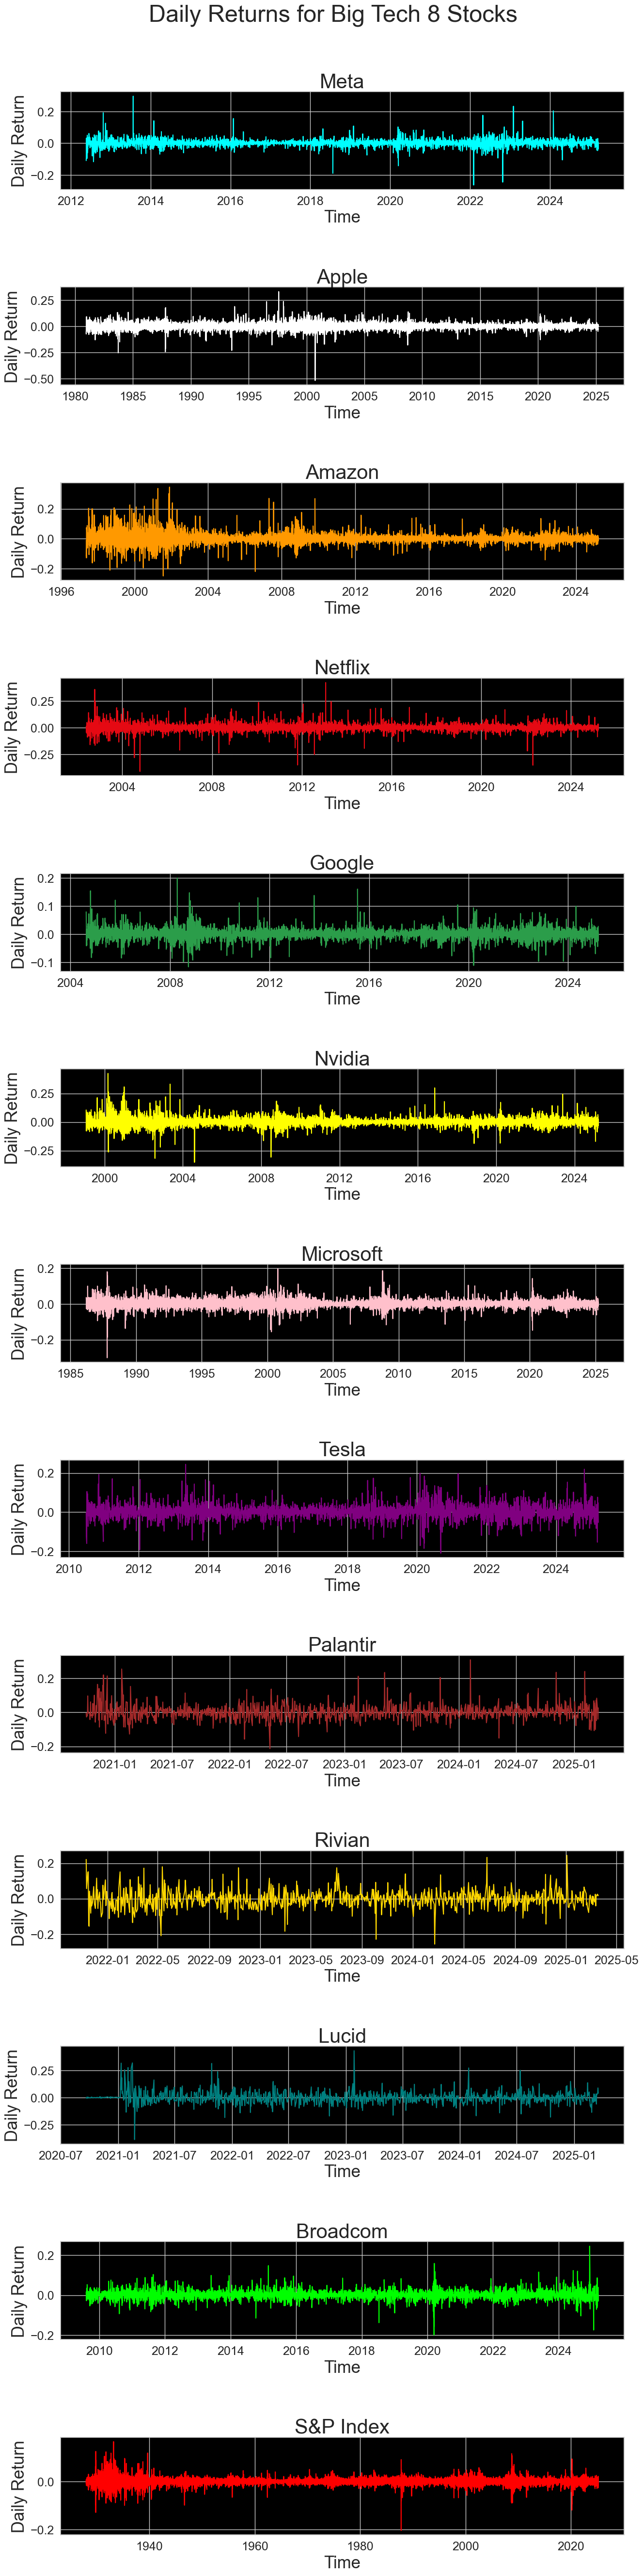

In [16]:
def visualize_faang_daily_return(df_meta, df_aapl, df_amzn, df_nflx, df_goog, df_nvda, df_msft, df_tsla, df_pltr, df_rivn, df_lcid, df_avgo, df_gspc):

    fig, axes = plt.subplots(13, 1, figsize=(15, 60), dpi=100)
    
    plt.suptitle('Daily Returns for Big Tech 8 Stocks', verticalalignment='top', horizontalalignment='center', fontsize=35)

    tickers = [
        (df_meta, "Meta", 'cyan'),
        (df_aapl, "Apple", 'white'),
        (df_amzn, "Amazon", '#FF9900'),
        (df_nflx, "Netflix", '#E50913'),
        (df_goog, "Google", '#2B9D4A'),
        (df_nvda, "Nvidia", 'yellow'),
        (df_msft, "Microsoft", 'pink'),
        (df_tsla, "Tesla", 'purple'),
        (df_pltr, "Palantir", 'brown'),
        (df_rivn, "Rivian", 'gold'),
        (df_lcid, "Lucid", 'teal'),
        (df_avgo, "Broadcom", 'lime'),
        (df_gspc, "S&P Index", 'red')
    ]

    for i, (df, title, color) in enumerate(tickers):
        axes[i].set_facecolor('black')
        axes[i].plot(df['Date'], df['Daily Return'], color=color)
        axes[i].set_title(title, fontsize=30)
        axes[i].set_xlabel('Time', fontsize=25)
        axes[i].set_ylabel('Daily Return', fontsize=25)
        axes[i].xaxis.set_tick_params(labelsize=18)
        axes[i].yaxis.set_tick_params(labelsize=18)
    
    plt.subplots_adjust(top=0.95,hspace=1.0)
    plt.show()

# Call the function with your dataframes
visualize_faang_daily_return(new_meta_df, new_aapl_df, new_amzn_df, new_nflx_df, new_goog_df, new_nvda_df, new_msft_df, new_tsla_df, new_pltr_df, new_rivn_df, new_lcid_df, new_avgo_df, new_gspc_df)


1. Meta (Blue graph):
Displays relatively stable returns, with some periods of increased volatility around 2020. The returns mostly range between -0.1 and 0.1, indicating moderate fluctuation on a day-to-day basis.
2. Apple (White graph):
Shows more consistency in daily returns over the years. Despite a few spikes, particularly noticeable in the late 1980s and early 2020s, the daily returns for Apple remain within a narrower band, suggesting less volatility compared to other stocks.
3. Amazon (Yellow graph):
This stock demonstrates increased volatility, with a visible expansion in the range of returns starting around 2000. The wider spread between the highest and lowest returns each day suggests higher risk and potentially higher rewards for investors.
4. Netflix (Red graph):
Exhibits high volatility, especially noticeable from 2010 onwards. The returns have frequent and significant spikes both upwards and downwards, reflecting Netflix’s dynamic market conditions and potentially the impact of varying subscriber growth rates and market competition.
5. Google (Green graph):
Indicates a steady pattern of daily returns with spikes in volatility around 2008 and 2020. This could correspond to major market events such as the financial crisis and the COVID-19 pandemic. The returns are mostly positive, highlighting the company's strong market position.
6. Nvidia (Yellow graph):
Shows an increasing trend in volatility, particularly from around 2016 onwards. This could be due to Nvidia’s significant role in the growing tech sectors like gaming and artificial intelligence, which can lead to large swings in stock price based on product success and industry trends.
7. Microsoft (Purple graph):
Displays periods of both stability and high volatility. Notable spikes can be seen during the early 2000s dot-com bubble and again during the financial crisis. Recent years show more stability, reflecting its established software and cloud services.
8. Tesla (Pink graph):
This graph shows high volatility throughout its history, with the daily returns frequently moving between extremes. This reflects Tesla's status as a highly speculative investment, with significant price swings driven by factors like product launches, regulatory news, and executive actions.